In [ ]:
import numpy as np
from scipy.spatial.distance import euclidean
import scipy
import torch

import dtw
import dtwalign
from fastdtw import fastdtw

from sklearn.manifold import TSNE
import pandas as pd

from src.speech_classification.audio_processing import AudioPreprocessorFbank, SpeechCommandsDataCollector
from src.siamese_net_sound_similarity.slstm_train import SiameseSpeechCommandsDataCollector, StochasticSiameseLSTMNet
from src.siamese_net_sound_similarity.train import SiameseLSTMNet

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()

%matplotlib inline

## Load data

In [2]:
wanted_words = ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left',
                'marvin',
                'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two',
                'up', 'wow', 'yes', 'zero']

wanted_words_combined = wanted_words

model_settings = {
    'dct_coefficient_count': 26,
    'label_count': len(wanted_words_combined) + 2,
    'hidden_reccurent_cells_count': 128,
    'winlen': 0.04,
    'winstep': 0.02
}

In [3]:
preproc = AudioPreprocessorFbank(nfilt=model_settings['dct_coefficient_count'], winlen=model_settings['winlen'],
                                     winstep=model_settings['winstep'])

data_iter = SiameseSpeechCommandsDataCollector(preproc,
                                        data_dir=r'C:\Study\Speech_command_classification\speech_dataset',
                                        wanted_words=wanted_words_combined,
                                        testing_percentage=10,
                                        validation_percentage=10
                                        )

index_to_word = {v:k for k,v in data_iter.word_to_index.items()}

# Gather Data for analysis

In [5]:
n_mini_batch_size = 1000

# gather data


data = data_iter.get_data(n_mini_batch_size, 0, 'training')
labels = data['y']

duplicates = data_iter.get_duplicates(labels, 0, 'training')
assert np.any(labels == duplicates['y'])

non_duplicates = data_iter.get_nonduplicates(labels, 0, 'training')
assert np.any(labels != non_duplicates['y'])


In [17]:
# load nn

nn_fname = r'C:/Study/SpeechAcquisitionModel/reports/seamise_net_10_01_2019_03_37_PM/net_0.46875.net'

nn = torch.load(nn_fname)

In [18]:
nn_input = torch.from_numpy(data['x']).cuda().float()

In [19]:
z, *_ = nn.single_forward(nn_input)
z = z.detach().cpu().numpy()

duplicates_z, *_ = nn.single_forward(torch.from_numpy(duplicates['x']).cuda().float())
duplicates_z = duplicates_z.detach().cpu().numpy()

non_duplicates_z, *_ = nn.single_forward(torch.from_numpy(non_duplicates['x']).cuda().float())
non_duplicates_z = non_duplicates_z.detach().cpu().numpy()

## Visuialize embedding space with t-SNE

### Whole sequence (visualize trajectories in the embedding space)

In [ ]:
# whole_dataset = np.concatenate([z, duplicates_z, non_duplicates_z])
whole_dataset = z
whole_dataset = whole_dataset[:, :, :]

# whole_dataset_flatten = whole_dataset.reshape(whole_dataset.shape[0], -1)
whole_dataset_flatten = whole_dataset.reshape(-1, whole_dataset.shape[-1])

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(whole_dataset_flatten)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


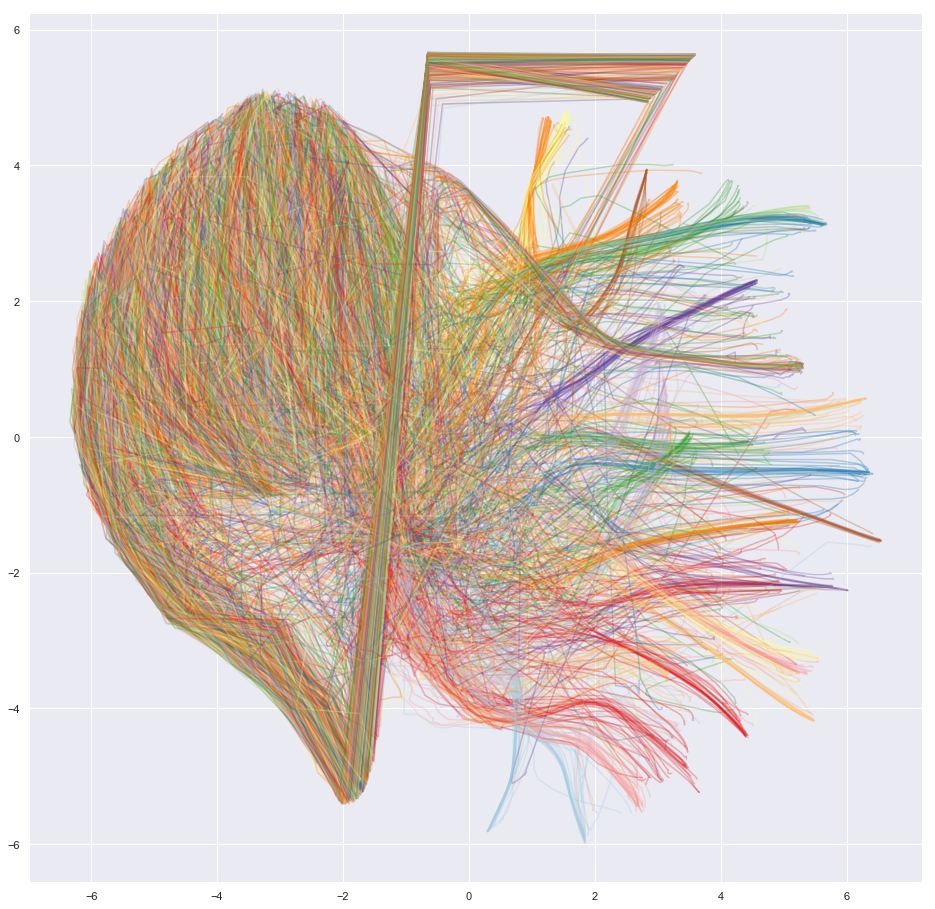

In [10]:
seq_len = whole_dataset.shape[1]
sizes = np.linspace(0.1, 1.0, seq_len)
plt.figure(figsize=(16,16))

for k in range(1000):
      sns.lineplot(
        x=tsne_results[k*seq_len:(k+1)*(seq_len), 0], y=tsne_results[k*seq_len:(k+1)*(seq_len), 1],
        color=sns.color_palette("Paired", 50)[int(labels[k])],
#         hue=sizes,
#          palette=sns.color_palette("hls", 30),
        
        legend="full",
        alpha=0.3,
        sort=False,

    )
# sns.lineplot(
#     x="t-SNE 1 dim", y="t-SNE 2 dim",
#     hue="y",
# #     palette=sns.color_palette("hls", 10),
#     data=df,
#     legend="full",
#     alpha=0.3,
#     sort=False
# )

<IPython.core.display.Javascript object>


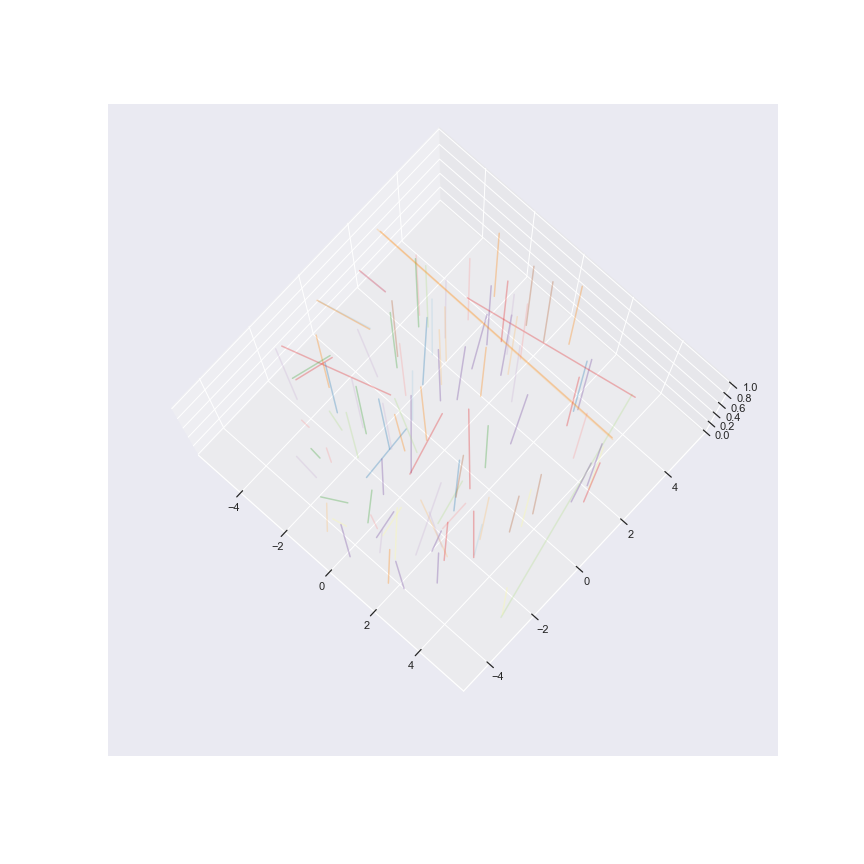

In [41]:
%matplotlib notebook

seq_len = whole_dataset.shape[1]
sizes = np.linspace(0.1, 1.0, seq_len)
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

for k in range(100):
      ax.plot(
        xs=tsne_results[k*seq_len + 30:(k+1)*(seq_len), 0], ys=tsne_results[k*seq_len + 30:(k+1)*(seq_len), 1], zs = np.arange(0, seq_len-30),
        color=sns.color_palette("Paired", 50)[int(labels[k])],
#         hue=sizes,
#          palette=sns.color_palette("hls", 30),
        
        
        alpha=0.3,
#         sort=False,

    )

### Last element  (visualize last frame of input in the embedding space)

In [20]:
n_mini_batch_size = 3000

# gather data


data_big = data_iter.get_data(n_mini_batch_size, 0, 'training')
labels = data_big['y']
nn_input = torch.from_numpy(data_big['x']).cuda().float()

In [21]:
z, *_ = nn.single_forward(nn_input)
z = z.detach().cpu().numpy()

# whole_dataset = np.concatenate([z, duplicates_z, non_duplicates_z])
whole_dataset = z
whole_dataset = whole_dataset[:, -1:, :].squeeze()


In [22]:
tsne_last_elem = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, metric='euclidean')
tsne_results_last_elem = tsne_last_elem.fit_transform(whole_dataset)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.007s...
[t-SNE] Computed neighbors for 3000 samples in 0.654s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.459810
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.320549
[t-SNE] Error after 300 iterations: 1.062326


In [23]:
# labels = np.concatenate([data['y'], duplicates['y'], non_duplicates['y']])
labels = data_big['y']

labels_words = []
for i in range(len(labels)):
    labels_words.extend([index_to_word[labels[i]]])
#     labels_words.extend([index_to_word[labels[i]]])


print(len(labels_words))
    
df = pd.DataFrame({'t-SNE 1 dim' : tsne_results_last_elem[:, 0], 
                  't-SNE 2 dim' : tsne_results_last_elem[:, 1],
                  'y': labels_words})

3000


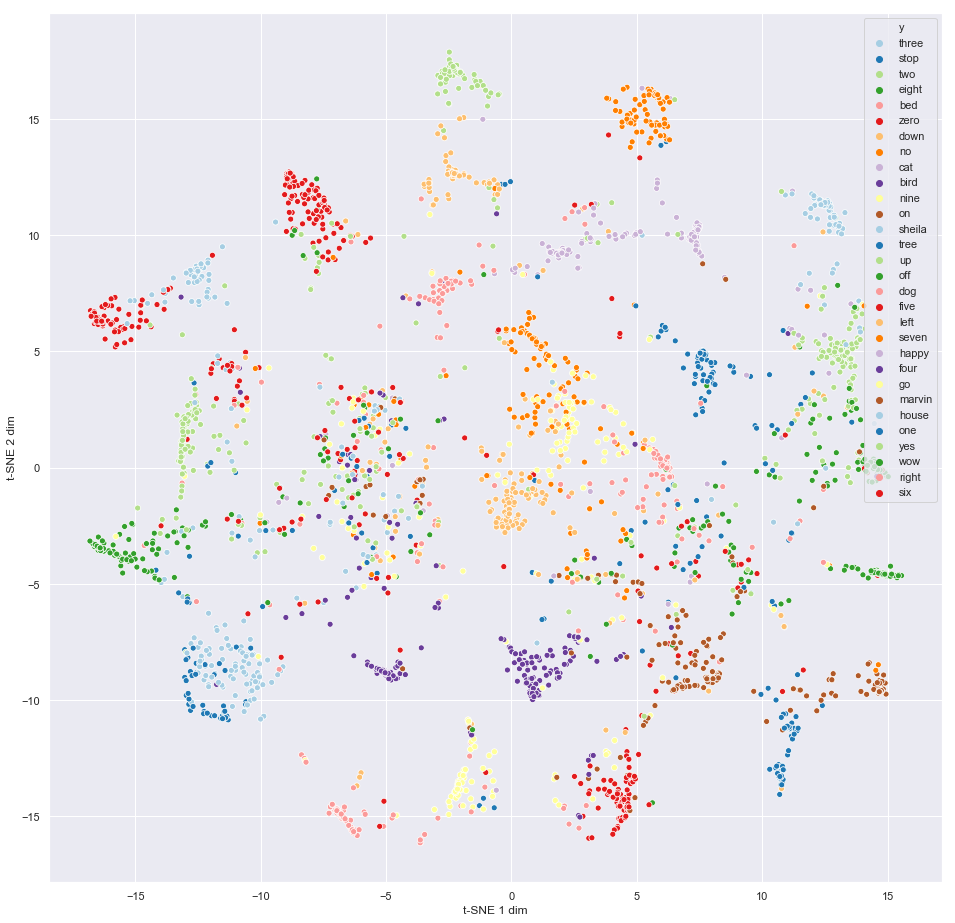

In [24]:
%matplotlib inline
plt.figure(figsize=(16,16))
my_palette = sns.color_palette("Paired", 30)
ax = sns.scatterplot(x="t-SNE 1 dim", y="t-SNE 2 dim", hue="y", data=df, palette=my_palette)